# Team ID: 7
## Project
Learning the graphical structure of electronic health records with graph convolutional transformer
## Member
Chaochao Zhou (cz76@illinois.edu)
## Github Link
https://github.com/zcc861007/EHR-GCT

# Before you use this template

This template is just a recommended template for project Report. It only considers the general type of research in our paper pool. Feel free to edit it to better fit your project. You will iteratively update the same notebook submission for your draft and the final submission. Please check the project rubriks to get a sense of what is expected in the template.

---

# FAQ and Attentions
* Copy and move this template to your Google Drive. Name your notebook by your team ID (upper-left corner). Don't eidt this original file.
* This template covers most questions we want to ask about your reproduction experiment. You don't need to exactly follow the template, however, you should address the questions. Please feel free to customize your report accordingly.
* Any report must have run-able codes and necessary annotations (in text and code comments).
* The notebook is like a demo and only uses small-size data (a subset of original data or processed data), the entire runtime of the notebook including data reading, data process, model training, printing, figure plotting, etc,
must be within 8 min, otherwise, you may get penalty on the grade.
  * If the raw dataset is too large to be loaded  you can select a subset of data and pre-process the data, then, upload the subset or processed data to Google Drive and load them in this notebook.
  * If the whole training is too long to run, you can only set the number of training epoch to a small number, e.g., 3, just show that the training is runable.
  * For results model validation, you can train the model outside this notebook in advance, then, load pretrained model and use it for validation (display the figures, print the metrics).
* The post-process is important! For post-process of the results, please use plots/figures. The code to summarize results and plot figures may be tedious, however, it won't be waste of time since these figures can be used for presentation. While plotting in code, the figures should have titles or captions if necessary (e.g., title your figure with "Figure 1. xxxx")
* There is not page limit to your notebook report, you can also use separate notebooks for the report, just make sure your grader can access and run/test them.
* If you use outside resources, please refer them (in any formats). Include the links to the resources if necessary.

# Mount Notebook to Google Drive
Upload the data, pretrianed model, figures, etc to your Google Drive, then mount this notebook to Google Drive. After that, you can access the resources freely.

Instruction: https://colab.research.google.com/notebooks/io.ipynb

Example: https://colab.research.google.com/drive/1srw_HFWQ2SMgmWIawucXfusGzrj1_U0q

Video: https://www.youtube.com/watch?v=zc8g8lGcwQU

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

# Introduction
This is an introduction to your report, you should edit this text/mardown section to compose. In this text/markdown, you should introduce:

*   Background of the problem
  * what type of problem: disease/readmission/mortality prediction, feature engineeing, data processing, etc\
  `In this project, we attempt to reconstruct the graph structure of diagnoses and treatments in a single visit, while predicting the readmission based on the learned embedding of the single visit.`
  * what is the importance/meaning of solving the problem\
  `Previous studies (e.g., MiME) have demonstrated that incorporating the hierarchical structures in EHR data, such as the relations between diagnosis and treatments, can significantly boost accuracy of prediction tasks, such as heart failure prediction. `
  * what is the difficulty of the problem\
  `However, most publicly available EHR data do not always contain the entire structure information. In particular, when it comes to claims data, such structure information is completely unavailable.`
  * the state of the art methods and effectiveness.\
  `Many graph networks can be described as different ways to aggregate a given node’s neighbor information, combine it with the given node, and derive the node’s latent representation (Xu et al. 2019). Some recent works focused on the connection between the Transformer’s self-attention and graph networks (Battagliaet al. 2018). Graph Attention Networks (Velickovic et al. 2018) applied self-attention on top of the adjacency matrix to learn non-static edge weights, and (Wang et al. 2018) used self-attention to capture non-local dependencies in images.`
*   Paper explanation
  * what did the paper propose\
  `The authors proposed Graph Convolutional Transformer (GCT), a novel approach to jointly learn the hidden encounter structure while performing various prediction tasks when the structure information is unavailable.`
  * what is the innovations of the method\
  `Learning effective patterns from raw EHR data is an essential step for improving the performance of many downstream prediction tasks. The work addressed the issue where the previous state-of-the-art method required the complete encounter structure information, and proposed GCT to capture the underlying encounter structure when the structure information is unknown.`
  * how well the proposed method work (in its own metrics)\
  `Table 4 shows the readmission prediction and mortality prediction performance of all models on eICU. As shown by GCT’s superior performance, it is evident that readmission prediction benefits from using the latent encounter structure.`
  ![Prediction_performance.png](https://drive.google.com/uc?id=1S_hs9NrIl7_6-5f_nkhrUfiDRyps5_Vu)
  * what is the contribution to the reasearch regime (referring the Background above, how important the paper is to the problem).\
  `Transformer is a suitable basis model to learn the hidden EHR structure, and the proposed Graph Convolutional Transformer uses data statistics to guide the structure learning process. The proposed model consistently outperformed previous approaches empirically, on both synthetic data and publicly available EHR data, for various prediction tasks such as graph reconstruction and readmission prediction, indicating that it can serve as an effective general-purpose representation learning algorithm for EHR data.`


* List hypotheses from the paper you will test and the corresponding experiments you will run.
  1.   Hypothesis 1: \
       `GCT can rescontruct the graph structure in a single visit. To test it, we will plot the graph structure, represtned by the confusion matrix of the attention scores.`
  2.   Hypothesis 2: \
       `Prediction performance can be improved by introducing prior condictional probabilities, based on the fact that some connections are not allowed in the encounter record (e.g., dignosis codes can only connect to treatments, instead of themselves), and unallowed connections can be represented by a mask M for attention scores. We will compared the performance with and without introducing piror`


# Methodology

This methodology is the core of your project. It consists of run-able codes with necessary annotations to show the expeiment you executed for testing the hypotheses.

The methodology at least contains two subsections **data** and **model** in your experiment.

In [34]:
PROJ_DIR = '/content/drive/My Drive/Courses/CS598-DL4H/project'

## import  packages you need
import tensorflow as tf
import numpy as np
import os, sys
import matplotlib.pyplot as plt
import seaborn as sns

# print(os.path.exists(PROJ_DIR))
sys.path.append(PROJ_DIR)
from graph_convolutional_transformer import *


##  Data
Data includes raw data (MIMIC III tables), descriptive statistics (our homework questions), and data processing (feature engineering).
  * Source of the data: where the data is collected from; if data is synthetic or self-generated, explain how. If possible, please provide a link to the raw datasets.\
  `The dataset adopted in this project is eICU Collaborative Research Dataset (https://physionet.org/content/eicu-crd/2.0/) inlcuding the patient, admissionDx, diagnosis, treatment CSV files`
  * Statistics: include basic descriptive statistics of the dataset like size, cross validation split, label distribution, etc.\
  `10 folds were generated. Each fold includes 32820 as training data, 4103 as validation data, 4103 as test data. In particular, this experiment only use fold 0 (please see prints below)`
  * Data process: how do you munipulate the data, e.g., change the class labels, split the dataset to train/valid/test, refining the dataset.\
  `GCT training requires an extraction of prior conditional probabilites from the raw eICU dataset. Due to the complicated preprocessing steps, we directly loaded the fold-0 processed data, performed using a code provided by the authors (please see *proc_eicu_python.ipynb* in our github repo). After preprocessing for each instance (each single visit), the features include diagonosis codes, procedure codes, and prior indices and values. The lable is readmission. (please see prints below)`
  * Illustration: printing results, plotting figures for illustration.\
  `Please see more details in the prints below.`
  * You can upload your raw dataset to Google Drive and mount this Colab to the same directory. If your raw dataset is too large, you can upload the processed dataset and have a code to load the processed dataset.\
  `Due to the complicated preprocessing steps, we directly upload the processed dataset. Data processing was performed in *proc_eicu_python.ipynb*`

Load processed data, and define training and validation generators for GCT model training

In [2]:
data_dir = os.path.join(PROJ_DIR, 'eicu_samples/proc_data/fold_0')
train_data_path = os.path.join(data_dir, 'train.tfrecord')
valid_data_path = os.path.join(data_dir, 'validation.tfrecord')
test_data_path = os.path.join(data_dir, 'test.tfrecord')

batch_size = 32
seqex_reader = SequenceExampleParser(batch_size=batch_size)

label_key='label.readmission'
train_generator = seqex_reader(train_data_path, label_key, True)
valid_generator = seqex_reader(valid_data_path, label_key, True)  # False break training !

train_generator_iter = iter(train_generator)
valid_generator_iter = iter(valid_generator)

List training and validation examples and number of batches (batch size = 32). Note the size of test data is exactly same as the validation data.

In [21]:
def count_examples_in_tfrecord(tfrecord_path):
    count = 0
    for record in tf.data.TFRecordDataset(tfrecord_path):
        count += 1
    return count

total_train_examples = count_examples_in_tfrecord(train_data_path)
print(f"Total training examples: {total_train_examples}")
total_train_batches = total_train_examples / batch_size
print(f"Total training batches: {total_train_batches}")

total_valid_examples = count_examples_in_tfrecord(valid_data_path)
print(f"Total validation examples: {total_valid_examples}")
total_valid_batches = total_valid_examples / batch_size
print(f"Total validation batches: {total_valid_batches}")

Total training examples: 32820
Total training batches: 1025.625
Total validation examples: 4103
Total validation batches: 128.21875


Show the structure of each sample, including the features and labels.

In [4]:
sample = next(train_generator_iter)
# print(len(sample))

features = sample[0]
labels = sample[1]

print('features', features.keys())
print('labels', labels.numpy())

for key in features.keys():
  print("Input data shape:", key, features[key].shape)

features dict_keys(['dx_ints', 'prior_indices', 'prior_values', 'proc_ints'])
labels [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
Input data shape: dx_ints (32, 1, 18)
Input data shape: prior_indices (32, 1, 2304)
Input data shape: prior_values (32, 1, 1152)
Input data shape: proc_ints (32, 1, 32)


In [5]:
# features['dx_ints']
# features['prior_indices']
# features['prior_values']
# features['proc_ints']

##   Model
The model includes the model definitation which usually is a class, model training, and other necessary parts.
  * Model architecture: layer number/size/type, activation function, etc\
  `We created a GCT consisting of three layers of multi-head convolutions. Based on the GCT, we further created an EHRTransformer to predict the readmission according to the diagnosis and treatments in a single visit. Note that the orignal codes provided by the authors were written using Tensorflow 1. Now, the model and training codes have been revised or rewitten for Tensorflow 2.`
  <img src="https://drive.google.com/uc?id=1tI-Ldh4rT8iAsIZcg34wi9EmBU48x307" width="500" height="350" alt="Model Architecture">

  * Training objectives: loss function, optimizer, weight of each loss term, etc\
  `Except a BCE loss with respect to the readmission labels, we further consider a regularization term for the training of the GCT. As shown in Eq. (4) above, we replace the attention mechanism in the first GCT block with the conditional probabilities P. The following blocks use the masked self-attention mechanism. However, we do not want GCT to drastically deviate from the informative P, but rather gradually improve upon P. Therefore, based on the fact that attention is itself a probability distribution, we sequentially penalize attention of j-th block if it deviates too much from the attention of (j – 1)-th block, using KL divergence. As shown by Eq. (4), the regularization terms are summed to the prediction loss term (e.g. negative log-likelihood), and the trade-off is controlled by the coefficient λ.`
  * Others: whether the model is pretrained, Monte Carlo simulation for uncertainty analysis, etc\
  `No pretraining was performed in this project.`
  * The code of model should have classes of the model, functions of model training, model validation, etc.\
  `A new class of EHRTransformer including the GCT provided by the authors was re-written, as the original codes were used in Tensorflow 1.`
  * If your model training is done outside of this notebook, please upload the trained model here and develop a function to load and test it.\
  `The trained models have been saved, and they will be loaded in this demo.`

A class of EHRTransformer including a three-layer GCT used to predict readmission in each single visit was re-defined, as the original applications were based on Tensorflow 1.

In [6]:
class EHRTransformer(tf.keras.Model):
    """Transformer-based EHR encounter modeling algorithm using Keras."""

    def __init__(self,
                gct_params,
                feature_keys=['dx_ints', 'proc_ints'],
                label_key='label.readmission',
                vocab_sizes={'dx_ints':3249, 'proc_ints':2210},
                feature_set='vdp',
                max_num_codes=50,
                prior_scalar=0.5,
                reg_coef=0.1,
                num_classes=1,
                # learning_rate=1e-3,
                # batch_size=32
                 ):

        super(EHRTransformer, self).__init__()
        self._feature_keys = feature_keys
        self._label_key = label_key
        self._vocab_sizes = vocab_sizes
        self._feature_set = feature_set
        self._max_num_codes = max_num_codes
        self._prior_scalar = prior_scalar
        self._reg_coef = reg_coef
        self._num_classes = num_classes
        # self._learning_rate = learning_rate
        # self._batch_size = batch_size

        self._gct_params = gct_params
        self._embedding_size = gct_params['embedding_size']
        self._num_transformer_stack = gct_params['num_transformer_stack']
        self._use_inf_mask = gct_params['use_inf_mask']
        self._use_prior = gct_params['use_prior']

        # Embedding layers for each feature key
        self.feature_embedder = FeatureEmbedder(self._vocab_sizes, self._feature_keys, self._embedding_size)

        # The Graph Convolutional Transformer as a Keras layer
        self.gct = GraphConvolutionalTransformer(**gct_params)

        # Output layer
        self.output_layer = tf.keras.layers.Dense(self._num_classes, activation=None)

    def call(self, features, training=False):
      # 1. Embedding lookup
      embedding_dict, mask_dict = self.feature_embedder.lookup(features, self._max_num_codes)

      # 2. Concatenate embeddings and masks into a single tensor.
      keys = ['visit'] + self._feature_keys
      embeddings = tf.concat([embedding_dict[key] for key in keys], axis=1)
      masks = tf.concat([mask_dict[key] for key in keys], axis=1)

      # 2-1. Create the guide matrix and the prior matrix.
      if self._feature_set == 'vdpl':
        guide, prior_guide = create_matrix_vdpl(features, masks, self._use_prior,
                                                self._use_inf_mask,
                                                self._max_num_codes,
                                                self._prior_scalar)
      elif self._feature_set == 'vdp':
        guide, prior_guide = create_matrix_vdp(features, masks, self._use_prior,
                                              self._use_inf_mask,
                                              self._max_num_codes,
                                              self._prior_scalar)
      else:
        sys.exit(0)

      # 3. Process embeddings with GCT
      hidden, attentions = self.gct(
          embeddings, masks[:, :, None], guide, prior_guide, training)

      # 4. Generate logits
      pre_logit = hidden[:, 0, :]
      pre_logit = tf.reshape(pre_logit, [-1, self._embedding_size])
      # logits = tf.layers.dense(pre_logit, self._num_classes, activation=None)
      logits = self.output_layer(pre_logit)
      logits = tf.squeeze(logits)
      probs = tf.nn.sigmoid(logits)

      predictions = {
          'probabilities': probs,
          'logits': logits,
          'attentions': attentions
      }
      return predictions

    def model(self):
        """Creates a functional API model for plotting and further analysis."""
        # inputs = {key: tf.keras.Input(shape=(None,), dtype=tf.int32, name=key) for key in self.feature_keys}

        inputs = {
            'dx_ints': tf.keras.Input([None, None, None], dtype=tf.int64),
            'proc_ints': tf.keras.Input([None, None, None], dtype=tf.int64),
            'prior_indices': tf.keras.Input([None, None, None], dtype=tf.int64),
            'prior_values': tf.keras.Input([None, None, None], dtype=tf.float32)
        }
        outputs = self.call(inputs)
        return tf.keras.Model(inputs=inputs, outputs=outputs)

    def get_loss(self, labels, logits, attentions):
      """Creates a loss tensor.

      Args:
        logits: Logits for prediction. This is obtained by calling get_prediction.
        labels: Labels for prediction.
        attentions: List of attention values from all layers of GCT. This is
          obtained by calling get_prediction.

      Returns:
        Loss tensor. If we use the conditional probability matrix, then GCT's
        attention mechanism will be regularized using KL divergence.
      """
      loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=labels, logits=logits)
      loss = tf.reduce_mean(loss)

      if self._use_prior:
        kl_terms = []
        attention_tensor = tf.convert_to_tensor(attentions)
        for i in range(1, self._num_transformer_stack):
          log_p = tf.math.log(attention_tensor[i - 1] + 1e-12)
          log_q = tf.math.log(attention_tensor[i] + 1e-12)
          kl_term = attention_tensor[i - 1] * (log_p - log_q)
          kl_term = tf.reduce_sum(kl_term, axis=-1)
          kl_term = tf.reduce_mean(kl_term)
          kl_terms.append(kl_term)

        reg_term = tf.reduce_mean(kl_terms)
        loss += self._reg_coef * reg_term

      return loss

Instantiate model and load trained weights

In [7]:
out_dir = os.path.join(PROJ_DIR, 'eicu_samples/results')
if not os.path.exists(out_dir):
    os.makedirs(out_dir)

gct_params = {
    "embedding_size": 128,
    "num_transformer_stack": 3,
    "num_feedforward": 2,
    "num_attention_heads": 1,
    "ffn_dropout": 0.08,
    "attention_normalizer": "softmax",
    "multihead_attention_aggregation": "concat",
    "directed_attention": False,
    "use_inf_mask": True,
    "use_prior": True,
}

model = EHRTransformer(gct_params=gct_params,
                      label_key='label.readmission',
                      reg_coef=0.1,
                      # learning_rate=0.00022,
                      # batch_size=32
                       )

model_save_path = os.path.join(out_dir, 'model.h5')

## Call the model first to bluid graph
predictions = model(features)
print(np.stack((labels, predictions['logits'], predictions['probabilities']), axis=-1).T)
print([attn.shape for attn in predictions['attentions']])

## Load trained model
if os.path.exists(model_save_path):
    model.load_weights(model_save_path)
    model_train_flag = False
    print('Found and loaded weights!')
else:
    model_train_flag = True
    print('No weights found!')

## To plot the model
# model.summary()
# tf.keras.utils.plot_model(model, show_shapes=True)

[[0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         1.
  0.         0.         0.         0.         0.         1.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.        ]
 [1.825388   1.1932524  1.3405111  2.0492744  1.6416557  1.5142674
  1.0303988  1.4470497  1.9939635  1.4885621  1.8484154  1.6511464
  1.942861   2.005053   1.8275868  1.2154385  1.5517519  2.0406861
  2.187853   1.9335147  1.8599982  1.5079296  1.8969772  1.6800896
  1.637783   2.360518   1.7250772  1.5147588  2.3115547  1.5801971
  2.0513313  2.1878529 ]
 [0.86121136 0.76732224 0.792574   0.88587433 0.8377601  0.8196928
  0.73699313 0.80954397 0.8801619  0.81586236 0.8639409  0.8390459
  0.87466615 0.8813266  0.861474   0.7712598  0.8251666  0.8850031
  0.8991535  0.873638   0.8652967  0.81875414 0.86954904 0.8429164
  0.83723307 0.9137666  0.8487817  0.8197653  0

Define customized training loop for Tensorflow 2. Particularly, the model was trained for 10 epochs for fold 0.

In [8]:
def run_train(model, optimizer, train_generator_iter, valid_generator_iter, model_save_path):
    # Initialize metrics
    train_loss = tf.keras.metrics.Mean(name='train_loss')
    valid_loss = tf.keras.metrics.Mean(name='valid_loss')
    train_auc_pr = tf.keras.metrics.AUC(name='train_auc_pr', curve='PR')
    valid_auc_pr = tf.keras.metrics.AUC(name='valid_auc_pr', curve='PR')
    train_auc_roc = tf.keras.metrics.AUC(name='train_auc_pr', curve='ROC')
    valid_auc_roc = tf.keras.metrics.AUC(name='valid_auc_pr', curve='ROC')

    # Prepare the training loop
    epochs = 10
    steps_per_epoch = 1000  # adjust this based on your generator
    validation_steps = 100  # adjust this based on your generator

    # Training loop
    history = {'train_loss': [], 'valid_loss': [],
              'train_auc_pr': [], 'valid_auc_pr': [],
              'train_auc_roc': [], 'valid_auc_roc': []}

    for epoch in range(epochs):
        print(f'\nStart of Epoch {epoch+1}')

        # Reset the metrics at the start of each epoch
        train_loss.reset_states()
        valid_loss.reset_states()
        train_auc_pr.reset_states()
        valid_auc_pr.reset_states()
        train_auc_roc.reset_states()
        valid_auc_roc.reset_states()

        # Iterate over the batches of the dataset.
        for step in range(steps_per_epoch):
            x_batch_train, y_batch_train = next(train_generator_iter)
            with tf.GradientTape() as tape:
                y_pred_train = model(x_batch_train, training=True)  # Forward pass
                loss = model.get_loss(y_batch_train, y_pred_train['logits'], y_pred_train['attentions'])

            gradients = tape.gradient(loss, model.trainable_weights)
            optimizer.apply_gradients(zip(gradients, model.trainable_weights))

            # Update training metrics
            train_loss.update_state(loss)
            train_auc_pr.update_state(y_batch_train, y_pred_train['probabilities'])
            train_auc_roc.update_state(y_batch_train, y_pred_train['probabilities'])

        # Display metrics at the end of each epoch.
        train_loss_result = train_loss.result()
        train_auc_pr_result = train_auc_pr.result()
        train_auc_roc_result = train_auc_roc.result()

        print(f'Training loss: {train_loss_result} - Train AUC-PR: {train_auc_pr_result} - Train AUC-ROC: {train_auc_roc_result}')

        # Validation loop
        for step in range(validation_steps):
            x_batch_val, y_batch_val = next(valid_generator_iter)
            y_pred_val = model(x_batch_val, training=False)
            v_loss = model.get_loss(y_batch_val, y_pred_val['logits'], y_pred_val['attentions'])

            # Update validation metrics
            valid_loss.update_state(v_loss)
            valid_auc_pr.update_state(y_batch_val, y_pred_val['probabilities'])
            valid_auc_roc.update_state(y_batch_val, y_pred_val['probabilities'])

        valid_loss_result = valid_loss.result()
        valid_auc_pr_result = valid_auc_pr.result()
        valid_auc_roc_result = valid_auc_roc.result()

        print(f'Validation loss: {valid_loss_result} - Valid AUC-PR: {valid_auc_pr_result} - Valid AUC-ROC: {valid_auc_roc_result}')

        # Append history
        history['train_loss'].append(train_loss_result.numpy())
        history['valid_loss'].append(valid_loss_result.numpy())
        history['train_auc_pr'].append(train_auc_pr_result.numpy())
        history['valid_auc_pr'].append(valid_auc_pr_result.numpy())
        history['train_auc_roc'].append(train_auc_roc_result.numpy())
        history['valid_auc_roc'].append(valid_auc_roc_result.numpy())

        # Save the model
        model.save_weights(model_save_path)

    return history

Plot training history including loss, AUC-PR, and AUC-ROC

In [9]:
def plot_history(history):
    plt.figure(figsize=(16, 3))
    plt.subplot(1, 3, 1)
    plt.plot(history['train_loss'], label='Training Loss')
    plt.plot(history['valid_loss'], label='Validation Loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 3, 2)
    plt.plot(history['train_auc_pr'], label='Training AUC-PR')
    plt.plot(history['valid_auc_pr'], label='Validation AUC-PR')
    plt.title('AUC-PR Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('AUC-PR')
    plt.legend()

    plt.subplot(1, 3, 3)
    plt.plot(history['train_auc_roc'], label='Training AUC-ROC')
    plt.plot(history['valid_auc_roc'], label='Validation AUC-ROC')
    plt.title('AUC-ROC Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('AUC-ROC')
    plt.legend()

    plt.show()

In [10]:
if model_train_flag:
  optimizer = tf.keras.optimizers.Adam(
      learning_rate=0.00022,
      beta_1=0.9,
      beta_2=0.999,
      epsilon=1e-8
  )

  history = run_train(model, optimizer, train_generator_iter, valid_generator_iter, model_save_path)

```
Start of Epoch 1
Training loss: 0.5123576521873474 - Train AUC-PR: 0.4286962151527405 - Train AUC-ROC: 0.7313898801803589
Validation loss: 0.655769944190979 - Valid AUC-PR: 0.20133599638938904 - Valid AUC-ROC: 0.5213701725006104

Start of Epoch 2
Training loss: 0.5033928155899048 - Train AUC-PR: 0.44760653376579285 - Train AUC-ROC: 0.7423446178436279
Validation loss: 0.6576829552650452 - Valid AUC-PR: 0.2468477189540863 - Valid AUC-ROC: 0.5706444382667542

Start of Epoch 3
Training loss: 0.4995952546596527 - Train AUC-PR: 0.45952650904655457 - Train AUC-ROC: 0.7477632761001587
Validation loss: 0.609856128692627 - Valid AUC-PR: 0.2893657088279724 - Valid AUC-ROC: 0.6159980297088623

Start of Epoch 4
Training loss: 0.4905339479446411 - Train AUC-PR: 0.47239115834236145 - Train AUC-ROC: 0.7580344080924988
Validation loss: 0.5576832294464111 - Valid AUC-PR: 0.27166634798049927 - Valid AUC-ROC: 0.6391111612319946

Start of Epoch 5
Training loss: 0.48910704255104065 - Train AUC-PR: 0.4865301251411438 - Train AUC-ROC: 0.7631182670593262
Validation loss: 0.5334770083427429 - Valid AUC-PR: 0.2784820795059204 - Valid AUC-ROC: 0.6690179109573364

Start of Epoch 6
Training loss: 0.48491713404655457 - Train AUC-PR: 0.49554377794265747 - Train AUC-ROC: 0.7683243155479431
Validation loss: 0.6274268627166748 - Valid AUC-PR: 0.3593043386936188 - Valid AUC-ROC: 0.6864175200462341

Start of Epoch 7
Training loss: 0.48225486278533936 - Train AUC-PR: 0.5029845833778381 - Train AUC-ROC: 0.7726529240608215
Validation loss: 0.5892007946968079 - Valid AUC-PR: 0.3575628399848938 - Valid AUC-ROC: 0.6947113275527954

Start of Epoch 8
Training loss: 0.47971653938293457 - Train AUC-PR: 0.5135482549667358 - Train AUC-ROC: 0.7789130806922913
Validation loss: 0.5765193700790405 - Valid AUC-PR: 0.3151327073574066 - Valid AUC-ROC: 0.6690535545349121

Start of Epoch 9
Training loss: 0.47726982831954956 - Train AUC-PR: 0.5221516489982605 - Train AUC-ROC: 0.7844768762588501
Validation loss: 0.5684685707092285 - Valid AUC-PR: 0.21759498119354248 - Valid AUC-ROC: 0.6398235559463501

Start of Epoch 10
Training loss: 0.4770759046077728 - Train AUC-PR: 0.5241050124168396 - Train AUC-ROC: 0.7892040610313416
Validation loss: 0.6658788919448853 - Valid AUC-PR: 0.29958027601242065 - Valid AUC-ROC: 0.6587786674499512
```

In [11]:
if model_train_flag:
  plot_history(history)

![model-train.png](https://drive.google.com/uc?id=1O2jXhnajcsXaHYvH-wFRpCxND1KkPyf6)




# Results
In this section, you should finish training your model training or loading your trained model. That is a great experiment! You should share the results with others with necessary metrics and figures.

Please test and report results for all experiments that you run with:

*   specific numbers (accuracy, AUC, RMSE, etc)
*   figures (loss shrinkage, outputs from GAN, annotation or label of sample pictures, etc)


Load test (hold-out) data

In [24]:
# Load all test data in a batch (batch_size=129)

seqex_reader_test = SequenceExampleParser(batch_size=129)
test_generator = seqex_reader_test(test_data_path, label_key, False)
test_generator_iter = iter(test_generator)
test_samples = next(test_generator_iter)

test_features, test_labels = test_samples
for key in test_features.keys():
  print("Input data shape:", key, test_features[key].shape)
print('labels', len(test_labels.numpy()))

Input data shape: dx_ints (129, 1, 25)
Input data shape: prior_indices (129, 1, 1300)
Input data shape: prior_values (129, 1, 650)
Input data shape: proc_ints (129, 1, 23)
labels 129


In [31]:
def run_test(model, test_features, test_labels):
  test_auc_pr = tf.keras.metrics.AUC(name='test_auc_pr', curve='PR')
  test_auc_roc = tf.keras.metrics.AUC(name='test_auc_pr', curve='ROC')

  test_auc_pr.reset_states()
  test_auc_roc.reset_states()

  test_predictions = model(test_features)
  test_probabilities = test_predictions['probabilities']

  test_auc_pr.update_state(test_labels, test_probabilities)
  test_auc_roc.update_state(test_labels, test_probabilities)

  test_auc_pr_result = test_auc_pr.result().numpy()
  test_auc_roc_result = test_auc_roc.result().numpy()

  print("Test AUC-PR:", test_auc_pr_result)
  print("Test AUC-ROC:", test_auc_roc_result)

  return test_predictions

In [63]:
def plot_attentions(test_predictions, sample_idx=0):
  plt.figure(figsize=(12, 3))  # You can adjust the size as needed

  plt.subplot(1,3,1)
  sns.heatmap((test_predictions['attentions'][0][sample_idx,0,:,:].numpy()*255).astype('int64'),
              annot=False, fmt='d', cmap='Blues', cbar=True)
  plt.title('Layer 1')

  plt.subplot(1,3,2)
  sns.heatmap((test_predictions['attentions'][1][sample_idx,0,:,:].numpy()*255).astype('int64'),
              annot=False, fmt='d', cmap='Blues', cbar=True)
  plt.title('Layer 2')

  plt.subplot(1,3,3)
  sns.heatmap((test_predictions['attentions'][2][sample_idx,0,:,:].numpy()*255).astype('int64'),
              annot=False, fmt='d', cmap='Blues', cbar=True)
  plt.title('Layer 3')

  plt.show()

Readmission prediction accuracy

In [64]:
print('The accuracy of the full model:')
test_predictions = run_test(model, test_features, test_labels)

The accuracy of the full model:
Test AUC-PR: 0.17446125
Test AUC-ROC: 0.5473662


Graph structure of a single visit represented by learned attentions. Note that for the three-layer GCT, we plot attentions of each layer.

30


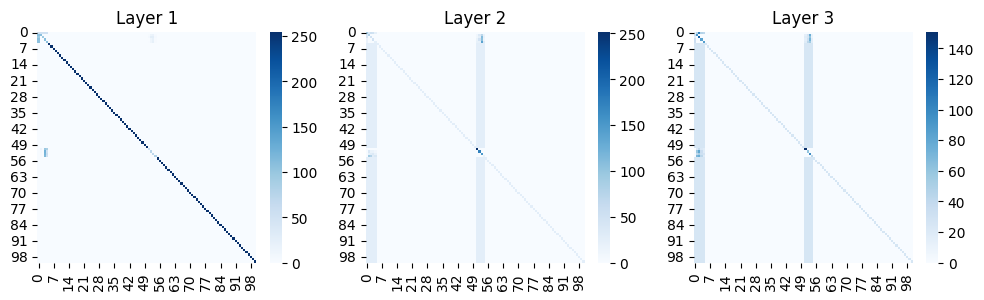

In [77]:
## Extract attentions of each layer (in total, three GCT layers) of a sample
sample_idx = np.random.randint(0, test_features['dx_ints'].shape[0])
print(sample_idx)

plot_attentions(test_predictions, sample_idx)

## Model comparison

Here, we preformed an ablation study. In the full model, we incorporated prior which pre-defined the allowed connections. In the ablated model, we did not use prior to train an EHRTransformer.

In [18]:
gct_params_ab = {
    "embedding_size": 128,
    "num_transformer_stack": 3,
    "num_feedforward": 2,
    "num_attention_heads": 1,
    "ffn_dropout": 0.08,
    "attention_normalizer": "softmax",
    "multihead_attention_aggregation": "concat",
    "directed_attention": False,
    "use_inf_mask": False,  # Without using inf mask in this ablation
    "use_prior": False,  # Without using piror in this ablation
}

model_ab = EHRTransformer(gct_params=gct_params_ab,
                      label_key='label.readmission',
                      reg_coef=0.1,)  # reg_coef is useless, when use_prior=False

model_ab_save_path = os.path.join(out_dir, 'model-ab.h5')

## Call the model first to bluid graph
predictions = model_ab(features)
print(np.stack((labels, predictions['logits'], predictions['probabilities']), axis=-1).T)
print([attn.shape for attn in predictions['attentions']])

## Load trained model
if os.path.exists(model_ab_save_path):
    model_ab.load_weights(model_ab_save_path)
    model_ab_train_flag = False
    print('Found and loaded weights!')
else:
    model_ab_train_flag = True
    print('No weights found!')

[[ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          1.
   0.          0.          0.          0.          0.          1.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.        ]
 [-0.7604154  -1.1729627  -0.45731398  0.48342597 -0.5608019  -1.2389009
  -0.02672277 -0.0999788  -0.39576653 -0.28954628  0.01875063 -0.33209765
  -0.04967374 -0.02367882 -1.2353911  -0.15060045 -0.58143634  0.37525222
   0.22875214 -0.64252937  0.05223966 -1.0029765  -1.1060609   0.41298258
  -0.9209578  -0.9982977  -0.04785047 -0.30897993 -0.47476968  0.469757
   1.0649253  -0.92210555]
 [ 0.31855607  0.2363199   0.3876232   0.61855656  0.36336192  0.22462736
   0.49331972  0.47502613  0.4023299   0.42811498  0.5046875   0.41773033
   0.48758414  0.4940806   0.22523925  0.46242088  0.35860217  0.5927275
   0.5569399   0.344675    0

In [ ]:
if model_ab_train_flag:
  optimizer = tf.keras.optimizers.Adam(
      learning_rate=0.00022,
      beta_1=0.9,
      beta_2=0.999,
      epsilon=1e-8
  )

  history_ab = run_train(model_ab, optimizer, train_generator_iter, valid_generator_iter, model_ab_save_path)

```
Start of Epoch 1
Training loss: 0.398379385471344 - Train AUC-PR: 0.42806676030158997 - Train AUC-ROC: 0.735192596912384
Validation loss: 0.5386015176773071 - Valid AUC-PR: 0.2188188135623932 - Valid AUC-ROC: 0.5117664337158203

Start of Epoch 2
Training loss: 0.38955000042915344 - Train AUC-PR: 0.4549289047718048 - Train AUC-ROC: 0.7503719329833984
Validation loss: 0.5774273872375488 - Valid AUC-PR: 0.2539457082748413 - Valid AUC-ROC: 0.5708601474761963

Start of Epoch 3
Training loss: 0.38462451100349426 - Train AUC-PR: 0.4724285900592804 - Train AUC-ROC: 0.7542656064033508
Validation loss: 0.5037546753883362 - Valid AUC-PR: 0.24321585893630981 - Valid AUC-ROC: 0.5673033595085144

Start of Epoch 4
Training loss: 0.3758658170700073 - Train AUC-PR: 0.48856642842292786 - Train AUC-ROC: 0.7677555680274963
Validation loss: 0.43910476565361023 - Valid AUC-PR: 0.27533912658691406 - Valid AUC-ROC: 0.6359612345695496

Start of Epoch 5
Training loss: 0.3717239499092102 - Train AUC-PR: 0.5010193586349487 - Train AUC-ROC: 0.7738065719604492
Validation loss: 0.4349829852581024 - Valid AUC-PR: 0.2478247582912445 - Valid AUC-ROC: 0.6135152578353882

Start of Epoch 6
Training loss: 0.3703138828277588 - Train AUC-PR: 0.5100313425064087 - Train AUC-ROC: 0.7782472372055054
Validation loss: 0.49198028445243835 - Valid AUC-PR: 0.3237912654876709 - Valid AUC-ROC: 0.6663386225700378

Start of Epoch 7
Training loss: 0.3617178201675415 - Train AUC-PR: 0.5289756059646606 - Train AUC-ROC: 0.7917959690093994
Validation loss: 0.48963966965675354 - Valid AUC-PR: 0.34653738141059875 - Valid AUC-ROC: 0.6660914421081543

Start of Epoch 8
Training loss: 0.35772833228111267 - Train AUC-PR: 0.5336450338363647 - Train AUC-ROC: 0.8001694679260254
Validation loss: 0.4741359055042267 - Valid AUC-PR: 0.2963450849056244 - Valid AUC-ROC: 0.6730717420578003

Start of Epoch 9
Training loss: 0.357424259185791 - Train AUC-PR: 0.545624315738678 - Train AUC-ROC: 0.8050689697265625
Validation loss: 0.4529169499874115 - Valid AUC-PR: 0.2288035750389099 - Valid AUC-ROC: 0.6346871852874756

Start of Epoch 10
Training loss: 0.35286688804626465 - Train AUC-PR: 0.5540690422058105 - Train AUC-ROC: 0.8148415088653564
Validation loss: 0.5516526103019714 - Valid AUC-PR: 0.3031543791294098 - Valid AUC-ROC: 0.6528646945953369
```

In [ ]:
if model_ab_train_flag:
  plot_history(history_ab)

![model-train.png](https://drive.google.com/uc?id=14mhINJFoLY42OQ2nXtUxWm6HI5CdoDCL)

Readmission prediction accuracy of the ablated model.

In [66]:
print('The accuracy of the ablated model:')
test_predictions_ab = run_test(model_ab, test_features, test_labels)

The accuracy of the ablated model:
Test AUC-PR: 0.28326017
Test AUC-ROC: 0.6240442


Graph structure of a single visit learned by the ablated model.

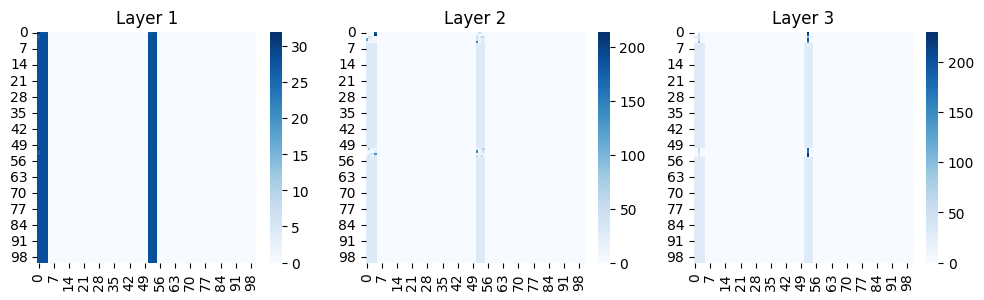

In [78]:
## Extract attentions of each layer (in total, three GCT layers) of a sample

plot_attentions(test_predictions_ab, sample_idx)

# Discussion

In this section,you should discuss your work and make future plan. The discussion should address the following questions:
  * Make assessment that the paper is reproducible or not.\
  `In this study, we reproduced the models and performed model training to reconstruct graph structure in each single visit and to predict readmission based on the information of each visit. However, we failed to test the second hypothesis that prediction performance can be improved by introducing prior condictional probabilities. Furthermore, we oberved very similar graph structures in final layer of the GCT in both the full and ablated model.`
  * Explain why it is not reproducible if your results are kind negative.\
  `The potential reason that the full model doesn't outperform the ablated model could be that in the paper, 10 folds were used to train 10 models, and accuracy was compuated based on the average of the 10 folds. However, we only train and test the models using one fold, due to limited computational resources.`
  * Describe “What was easy” and “What was difficult” during the reproduction.\
  `One challenge that we faced is that the original codes in the repo were provided using Tensorflow 1 and Python 2. Therefore, they cannot be directly run and models can be trained using the current version of machine learning frameworks. In this project, all codes have been revised or rewritten for Tensorflow 2 implementations.`
  * Make suggestions to the author or other reproducers on how to improve the reproducibility.\
  `We suggest that more folds (similar to ensemble) should be adopted to train and test the model performance.`
  * What will you do in next phase.\
  `First, we consider to create a version of PyTorch, in order to use PyHealth in the data preprocessing. Furthermore, the current implementation is based on a single encounter. We anticipate that the GCT can be readily combined with a sequence aggregator such as RNN or 1-D CNN to handle a sequence of encounters, and derive patient representations for patient-level prediction tasks.`



# References

1.   Choi, Edward, et al, Learning the graphical structure of electronic health records with graph convolutional transformer, Proceedings of the AAAI conference on artificial intelligence, 2020, 34:1, doi:
https://doi.org/10.48550/arXiv.1906.04716

